In [131]:
using Distributions,Gadfly,StatsFuns,InplaceOps
include("/home/seth/code/sparse_normal_categorical/normal_probit_gibbs.jl")

n = 1000;
K = 20;
y = [rand(Poisson(0.1),div(n,2)); rand(Poisson(10),div(n,4));rand(Poisson(30),div(n,4))];
prior = Dict{Symbol,Union{Int64,Float64,Array{Float64}}}(
:K=>K,:a0=>0.1,:b0=>0.01,:SigmaB0=>eye(1),:theta_dim=>(K));

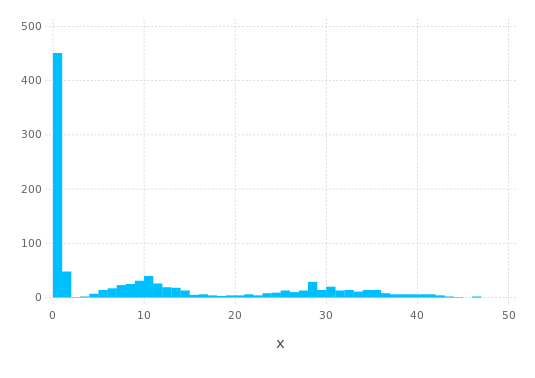

In [136]:
plot(x=y,Geom.histogram)

In [133]:
function llp(y::Int64,lambda::Float64)
    y*log(lambda) - lambda;
end

llp (generic function with 1 method)

In [137]:
@time out = psbpm(y,[],llp,sample_poisson,prior,0,100,20000);
out[:B] = reshape(out[:B],size(out[:B])[2:3]);

LoadError: LoadError: InterruptException:
while loading In[137], in expression starting on line 155

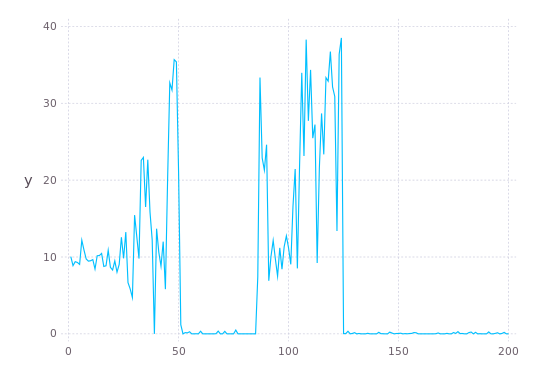

In [142]:
plot(y=out[:theta][4,:],Geom.line)

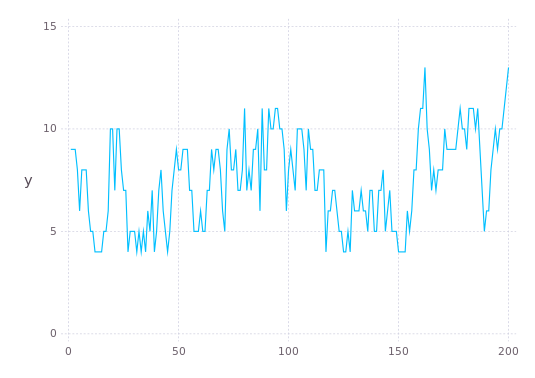

In [145]:
plot(y=mapslices(x -> length(unique(x)),out[:z],1),Geom.line)

In [144]:
foo = mapslices(x -> eta2p(ones((1,1)),x'),out[:B],1)


20x200 Array{Float64,2}:
 0.606978     0.431517     0.470057     …  0.34887      0.31676    
 0.210485     0.256629     0.22661         0.224334     0.225259   
 0.0617975    0.0815341    0.107179        0.24844      0.227198   
 0.0980179    0.157682     0.14788         0.119043     0.0735001  
 0.00520159   0.0148893    0.019578        0.0106091    0.0253579  
 0.00981696   0.02596      0.0159427    …  0.00285746   0.0389615  
 0.00441059   0.0210151    0.00826014      0.0160905    0.0408071  
 0.00153009   0.00665722   0.00352928      0.0118762    0.0266305  
 0.000814795  0.00138005   0.000265102     0.00258165   0.00477229 
 0.000650156  0.00205122   0.000617187     0.0133689    0.015468   
 0.000223156  0.000477149  7.87701e-5   …  0.000144822  0.000927543
 4.6109e-5    8.93118e-5   1.77967e-6      0.00115513   0.00286122 
 1.02008e-5   8.46651e-5   9.45254e-7      3.73673e-5   9.94782e-5 
 1.56209e-5   1.72609e-5   5.31232e-7      0.000290326  0.000356562
 1.10461e-6   1.05487e-

In [143]:
out[:B]

19x200 Array{Float64,2}:
  0.271452   -0.172514   -0.0751278  …  -0.220764   -0.388374   -0.476779  
  0.0892403  -0.122054   -0.182457      -0.0914083  -0.400132   -0.440762  
 -0.41643    -0.638883   -0.37633        0.815934    0.207277   -0.00981014
  0.884594    0.480667    0.686795      -0.0463426   0.432862   -0.471948  
 -0.742389   -0.823962   -0.238999      -0.531243   -0.919706   -0.989435  
  0.151792   -0.126831    0.139713   …  -1.00293    -1.56605    -0.537876  
  0.182917    0.415454    0.378969      -0.434231   -0.382735   -0.153608  
 -0.0885767   0.300084    0.79034       -0.371103   -0.255658    0.026555  
 -0.0946443  -0.425348   -0.59835       -0.513515   -1.06084    -0.889151  
  0.484662    0.673665    1.18608        1.98131     1.14475     0.659854  
  0.67454     0.515436    1.70428    …  -0.925475   -1.43929    -0.932675  
  0.305266   -0.175563   -0.0276442     -0.307926    0.377337    0.403139  
 -0.356233    0.571198    0.0206        -1.39942    -1.56067   